## **Introduction**

In this project, we aim to develop a robust machine learning model to detect phishing URLs using structured feature-based analysis. A dataset comprising 100,00 URLs was cleaned and prepared, with 17 binary features extracted to represent the characteristics of each URL.

To begin, exploratory data analysis (EDA) was performed to understand feature distributions, relationships, and class balance. The dataset was then split into an **80:20 ratio** for training and testing.

We evaluated several machine learning models, including:

* **Decision Tree (DT)**
* **Random Forest (RF)**
* **XGBoost**
* **LightGBM**

Each model was trained and optimized using **hyperparameter tuning** to enhance performance. After training, model performance was compared based on accuracy, precision, recall, F1-score and ROC-AUC.

Finally, the **best-performing model** was saved for deployment and inference on real-world URLs.

In [42]:
#importing required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn import metrics
import re
import math
import tldextract
import idna
from urllib.parse import urlparse, unquote
import validators
from collections import Counter
import warnings
from sklearn.feature_selection import VarianceThreshold
warnings.filterwarnings('ignore')

## **Loading Processed Dataset**
Ensure you load the **processed dataset**.

In [43]:
#Loading data into dataframe

df = pd.read_csv('url_dataset_processed.csv', quotechar='"')
df.head()

,url,result,entropyDomain,entropyurl,longUrl,suspiciousExtension,countDepth,countDot,hasHttps,suspiciousTld,suspiciousDomain,validateUrl,suspiciousWord,longDomain,hypenDomain,countDigitURL,countDigitDomain,openRedirect,uppercaseUrl
0,https://baseball-reference.com/bullpen/Novembe...,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,1
1,https://www.aboriginalartcoop.com.au/aborigina...,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0
2,http://c8r.97332e.p2e40d19v.5743fdy.823w.f7e3....,1,1,1,1,0,0,1,1,1,0,0,0,1,0,1,1,0,0
3,https://brokebackmountainmovie.com/,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,https://linkedin.com/pub/james-sly/7/a01/120,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


## **Familiarizing with Data & EDA**
In this step, few dataframe methods are used to look into the data and its features. From  DataFrame info, we can see:

* **Total entries: 100,000**
  
* **Columns: 19**
  
* **All columns have non-null values, which means there's no missing data.**
  
These columns include:

* **url (the raw URL)**

* **result (the label: 0 = legitimate, 1 = phishing)**
  
* **17 extracted features like entropyDomain, entropyurl, longUrl,suspiciousExtension, countDepth, countDot, hasHttps, suspiciousTld, suspiciousDomain, validateUrl, suspiciousWord, longDomain, hypenDomain, countDigitURL, countDigitDomain,openRedirect, and uppercaseUrl.**

In [44]:
#Shape of dataframe

df.shape

(100000, 19)

In [45]:
#Listing the features of the dataset

df.columns

Index(['url', 'result', 'entropyDomain', 'entropyurl', 'longUrl',
       'suspiciousExtension', 'countDepth', 'countDot', 'hasHttps',
       'suspiciousTld', 'suspiciousDomain', 'validateUrl', 'suspiciousWord',
       'longDomain', 'hypenDomain', 'countDigitURL', 'countDigitDomain',
       'openRedirect', 'uppercaseUrl'],
      dtype='object')

In [46]:
#Information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  100000 non-null  object
 1   result               100000 non-null  int64 
 2   entropyDomain        100000 non-null  int64 
 3   entropyurl           100000 non-null  int64 
 4   longUrl              100000 non-null  int64 
 5   suspiciousExtension  100000 non-null  int64 
 6   countDepth           100000 non-null  int64 
 7   countDot             100000 non-null  int64 
 8   hasHttps             100000 non-null  int64 
 9   suspiciousTld        100000 non-null  int64 
 10  suspiciousDomain     100000 non-null  int64 
 11  validateUrl          100000 non-null  int64 
 12  suspiciousWord       100000 non-null  int64 
 13  longDomain           100000 non-null  int64 
 14  hypenDomain          100000 non-null  int64 
 15  countDigitURL        100000 non-nul

In [47]:
# nunique value in columns

df.nunique()

url                    100000
result                      2
entropyDomain               2
entropyurl                  2
longUrl                     2
suspiciousExtension         2
countDepth                  2
countDot                    2
hasHttps                    2
suspiciousTld               2
suspiciousDomain            2
validateUrl                 2
suspiciousWord              2
longDomain                  2
hypenDomain                 2
countDigitURL               2
countDigitDomain            2
openRedirect                2
uppercaseUrl                2
dtype: int64

In [48]:
#description of dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
result,100000.0,0.50000,0.500003,0.0,0.0,0.5,1.0,1.0
entropyDomain,100000.0,0.48218,0.499685,0.0,0.0,0.0,1.0,1.0
entropyurl,100000.0,0.52349,0.499450,0.0,0.0,1.0,1.0,1.0
longUrl,100000.0,0.49382,0.499964,0.0,0.0,0.0,1.0,1.0
suspiciousExtension,100000.0,0.33267,0.471172,0.0,0.0,0.0,1.0,1.0
countDepth,100000.0,0.52277,0.499484,0.0,0.0,1.0,1.0,1.0
countDot,100000.0,0.35449,0.478361,0.0,0.0,0.0,1.0,1.0
hasHttps,100000.0,0.40121,0.490146,0.0,0.0,0.0,1.0,1.0
suspiciousTld,100000.0,0.25738,0.437193,0.0,0.0,0.0,1.0,1.0
suspiciousDomain,100000.0,0.05251,0.223054,0.0,0.0,0.0,0.0,1.0


## **Visualizing the data**
Few plots and graphs are displayed to find how the data is distributed and the how features are related to each other.

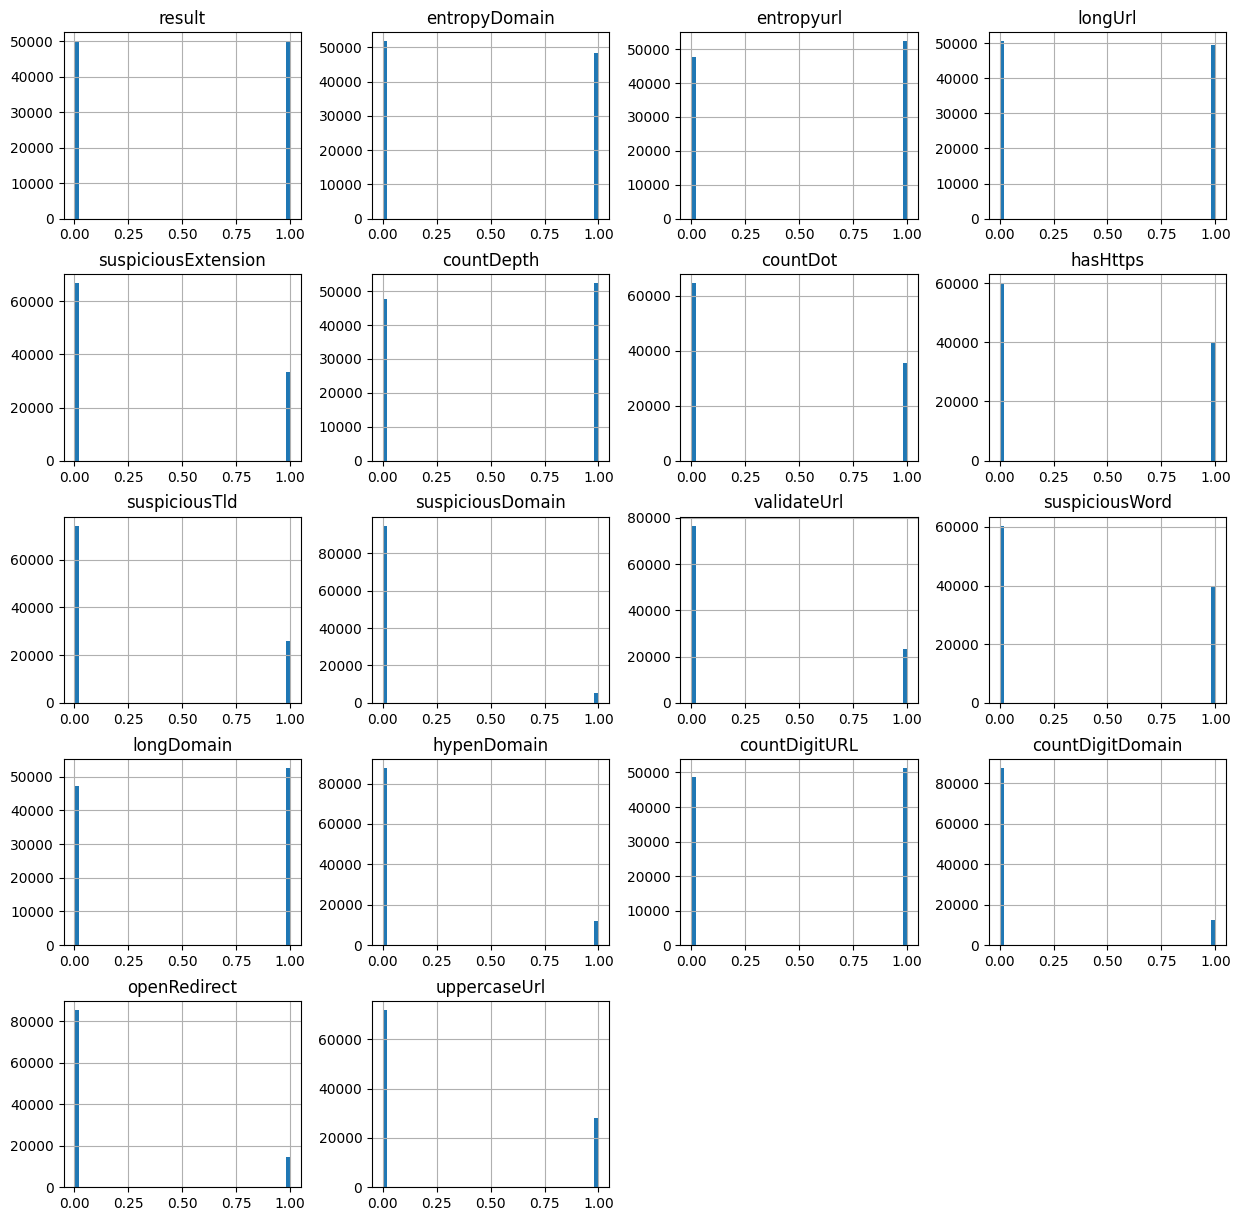

In [49]:
#Plotting the data distribution
df.hist(bins = 50,figsize = (15,15))
plt.show()

## **Correlation heatmap**
This correlation heatmap visually represents the relationships between different variables, with colors indicating the strength and direction of their correlations:

* **Strong positive correlations.** (red) suggest variables tend to increase together. For example, **result** has a strong positive correlation with **HTTPS** (0.82), meaning websites with HTTPS are more likely to be classified as safe.

* **Moderate positive correlations** (lighter red) show variables are related but not perfectly. **entropyUrl** and **longUrl** (0.65) indicate long URL and URL entropy are somewhat linked.

* **Weak or no correlation** (white) means the two variables have little to no direct relationship.

* **Negative correlations** (blue) suggest as one variable increases, the other tends to decrease. For instance, **validateUrl** and **entropyDomain** (-0.49).

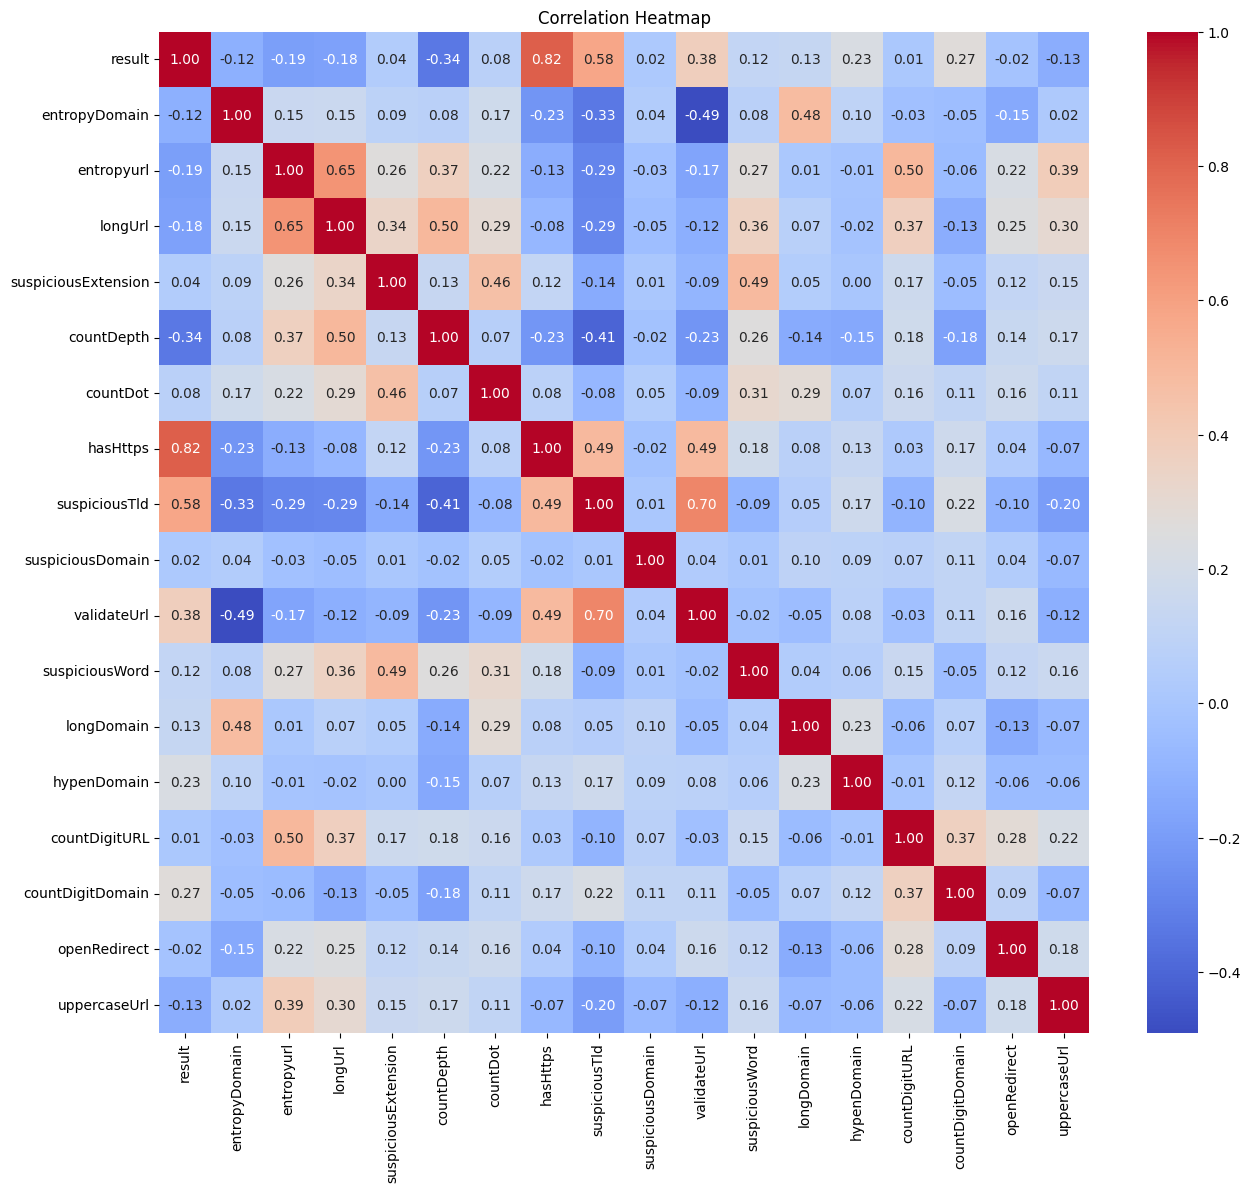

In [50]:
# You should exclude non-numeric columns before creating the heatmap
numeric_data = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Create the correlation heatmap
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [51]:
# shuffling the rows in the dataset so that when splitting the train and test set are equally distributed

data = df.sample(frac=1).reset_index(drop=True)
data.head()


,url,result,entropyDomain,entropyurl,longUrl,suspiciousExtension,countDepth,countDot,hasHttps,suspiciousTld,suspiciousDomain,validateUrl,suspiciousWord,longDomain,hypenDomain,countDigitURL,countDigitDomain,openRedirect,uppercaseUrl
0,https://www.picktorrent.com/torrents/18/annabe...,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0
1,https://www.flickr.com/photos/joweldon/4634026...,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0
2,https://agilitynut.com/mim/wind.html,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
3,https://death-records.net/rhodeisland/death-re...,0,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0
4,http://jobrajasthan.com/tt/Indexxatt(1).htm,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1


## **Splitting the Data**
The data is split into train & test sets, 80-20 split.

In [53]:
data.head()

,url,result,entropyDomain,entropyurl,longUrl,suspiciousExtension,countDepth,countDot,hasHttps,suspiciousTld,suspiciousDomain,validateUrl,suspiciousWord,longDomain,hypenDomain,countDigitURL,countDigitDomain,openRedirect,uppercaseUrl
0,https://www.picktorrent.com/torrents/18/annabe...,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0
1,https://www.flickr.com/photos/joweldon/4634026...,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0
2,https://agilitynut.com/mim/wind.html,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
3,https://death-records.net/rhodeisland/death-re...,0,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0
4,http://jobrajasthan.com/tt/Indexxatt(1).htm,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1


In [54]:
# Splitting the dataset into dependant and independant fetature
X = data.drop(['url','result'],axis =1)
y = data['result']

In [55]:
# Splitting the dataset into train and test sets: 80-20 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80000, 17), (80000,), (20000, 17), (20000,))

## **Model Building & Training:**
1. Decision Tree Classifier 
2. Random Forest Classifier
3. XGBoost Classifier
4. LightGBM Classifier

The metrics considered to evaluate the models performance are Accuracy & F1 score.

In [56]:
# Creating holders to store the model performance results
ML_Model = []
accuracy = []
f1_score = []
recall = []
precision = []
roc_auc = []

#function to call for storing the results
def storeResults(model, a,b,c,d,e):
  ML_Model.append(model)
  accuracy.append(round(a, 3))
  f1_score.append(round(b, 3))
  recall.append(round(c, 3))
  precision.append(round(d, 3))
  roc_auc.append(round(e, 3))

## **Decision Tree Classifier**
Decision Tree is a simple and intuitive classification algorithm that splits the dataset based on decision rules, much like a flowchart. It's easy to understand and interpret, making it great for beginners or situations where model transparency is important. However, decision trees can easily overfit the training data, especially if the tree is very deep, and they can be sensitive to small changes in the dataset.

In [57]:
# Decision Tree Classifier model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(random_state=42, max_depth= 20, min_samples_split=30, min_samples_leaf=1, max_features= 'sqrt', criterion='entropy', splitter='best')

# fit the model 
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       min_samples_split=30, random_state=42)

In [58]:
#predicting the target value from the model for the samples

y_train_tree = tree.predict(X_train)
y_test_tree = tree.predict(X_test)

In [59]:
#computing the accuracy, f1_score, recall, precision and ROC-AUC of the model performance

acc_train_tree = metrics.accuracy_score(y_train,y_train_tree)
acc_test_tree = metrics.accuracy_score(y_test,y_test_tree)
print("Decision Tree : Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree : Accuracy on test Data: {:.3f}".format(acc_test_tree))
print()

f1_score_train_tree = metrics.f1_score(y_train,y_train_tree)
f1_score_test_tree = metrics.f1_score(y_test,y_test_tree)
print("Decision Tree : f1_score on training Data: {:.3f}".format(f1_score_train_tree))
print("Decision Tree : f1_score on test Data: {:.3f}".format(f1_score_test_tree))
print()

recall_score_train_tree = metrics.recall_score(y_train,y_train_tree)
recall_score_test_tree = metrics.recall_score(y_test,y_test_tree)
print("Decision Tree : Recall on training Data: {:.3f}".format(recall_score_train_tree))
print("Decision Tree : Recall on test Data: {:.3f}".format(recall_score_test_tree))
print()

precision_score_train_tree = metrics.precision_score(y_train,y_train_tree)
precision_score_test_tree = metrics.precision_score(y_test,y_test_tree)
print("Decision Tree : precision on training Data: {:.3f}".format(precision_score_train_tree))
print("Decision Tree : precision on test Data: {:.3f}".format(precision_score_test_tree))
print()

roc_auc_score_train_tree = metrics.roc_auc_score(y_train,y_train_tree)
roc_auc_score_test_tree = metrics.roc_auc_score(y_test,y_test_tree)
print("Decision Tree : ROC-AUC on training Data: {:.3f}".format(roc_auc_score_train_tree))
print("Decision Tree : ROC-AUC on test Data: {:.3f}".format(roc_auc_score_test_tree))

Decision Tree : Accuracy on training Data: 0.960
Decision Tree : Accuracy on test Data: 0.959

Decision Tree : f1_score on training Data: 0.959
Decision Tree : f1_score on test Data: 0.957

Decision Tree : Recall on training Data: 0.935
Decision Tree : Recall on test Data: 0.934

Decision Tree : precision on training Data: 0.983
Decision Tree : precision on test Data: 0.982

Decision Tree : ROC-AUC on training Data: 0.960
Decision Tree : ROC-AUC on test Data: 0.958


In [61]:
# storing the results

storeResults('Decision Tree',acc_test_tree,f1_score_test_tree,
             recall_score_test_tree,precision_score_test_tree, roc_auc_score_test_tree)

## **Random Forest Classifier**
Random Forest improves upon decision trees by creating an ensemble (or "forest") of many decision trees, each trained on a slightly different subset of the data. This averaging technique reduces overfitting and typically results in better accuracy. Random Forest works well with both small and large datasets and is more robust, though it is less interpretable than a single decision tree and slower due to the multiple trees.

In [62]:
# Random Forest Classifier Model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(n_estimators=600, min_samples_split=30, min_samples_leaf=1, max_features= 'sqrt', max_depth = 20, n_jobs = -1, random_state=42)

# fit the model 
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_split=30, n_estimators=600,
                       n_jobs=-1, random_state=42)

In [63]:
# predicting the target value from the model for the samples
y_train_forest = forest.predict(X_train)
y_test_forest = forest.predict(X_test)

In [64]:
#computing the accuracy, f1_score, recall, precision and ROC-AUC of the model performance

acc_train_forest = metrics.accuracy_score(y_train,y_train_forest)
acc_test_forest = metrics.accuracy_score(y_test,y_test_forest)
print("Random Forest : Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random Forest : Accuracy on test Data: {:.3f}".format(acc_test_forest))
print()

f1_score_train_forest = metrics.f1_score(y_train,y_train_forest)
f1_score_test_forest = metrics.f1_score(y_test,y_test_forest)
print("Random Forest : f1_score on training Data: {:.3f}".format(f1_score_train_forest))
print("Random Forest : f1_score on test Data: {:.3f}".format(f1_score_test_forest))
print()

recall_score_train_forest = metrics.recall_score(y_train,y_train_forest)
recall_score_test_forest = metrics.recall_score(y_test,y_test_forest)
print("Random Forest : Recall on training Data: {:.3f}".format(recall_score_train_forest))
print("Random Forest : Recall on test Data: {:.3f}".format(recall_score_test_forest))
print()

precision_score_train_forest = metrics.precision_score(y_train,y_train_forest)
precision_score_test_forest = metrics.precision_score(y_test,y_test_forest)
print("Random Forest : precision on training Data: {:.3f}".format(precision_score_train_forest))
print("Random Forest : precision on test Data: {:.3f}".format(precision_score_test_forest))
print()

roc_auc_score_train_forest = metrics.roc_auc_score(y_train,y_train_forest)
roc_auc_score_test_forest = metrics.roc_auc_score(y_test,y_test_forest)
print("Random Forest : ROC-AUC on training Data: {:.3f}".format(roc_auc_score_train_forest))
print("Random Forest : ROC-AUC on test Data: {:.3f}".format(roc_auc_score_test_forest))

Random Forest : Accuracy on training Data: 0.961
Random Forest : Accuracy on test Data: 0.962

Random Forest : f1_score on training Data: 0.960
Random Forest : f1_score on test Data: 0.961

Random Forest : Recall on training Data: 0.937
Random Forest : Recall on test Data: 0.939

Random Forest : precision on training Data: 0.985
Random Forest : precision on test Data: 0.984

Random Forest : ROC-AUC on training Data: 0.961
Random Forest : ROC-AUC on test Data: 0.962


In [66]:
# storing the results

storeResults('Random Forest', acc_test_forest, f1_score_test_forest,
             recall_score_test_forest, precision_score_test_forest, roc_auc_score_test_tree)

## **XGBoost Classifier**
XGBoost (Extreme Gradient Boosting) is a powerful and widely used algorithm that builds trees sequentially, each one correcting the errors of the previous. It includes built-in regularization, which helps prevent overfitting, and it's known for achieving high accuracy in many machine learning competitions. However, XGBoost can be more complex to tune and requires more memory and computational time than simpler models.

In [67]:
# XGBoost Classifier Model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier( objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', n_jobs= -1, enable_categorical=True, colsample_bytree=0.8, learning_rate=0.01, max_depth=20, min_child_weight=1, n_estimators=600, random_state=42)

# fit the model 
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [68]:
# predicting the target value from the model for the samples
y_train_xgb = xgb.predict(X_train)
y_test_xgb = xgb.predict(X_test)

In [69]:
# computing the accuracy, f1_score, recall, precision, ROC-AUC of the model performance

acc_train_xgb = metrics.accuracy_score(y_train,y_train_xgb)
acc_test_xgb = metrics.accuracy_score(y_test,y_test_xgb)
print("XGBoost Classifier : Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost Classifier : Accuracy on test Data: {:.3f}".format(acc_test_xgb))
print()

f1_score_train_xgb = metrics.f1_score(y_train,y_train_xgb)
f1_score_test_xgb = metrics.f1_score(y_test,y_test_xgb)
print("XGBoost Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_xgb))
print("XGBoost Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_xgb))
print()

recall_score_train_xgb = metrics.recall_score(y_train,y_train_xgb)
recall_score_test_xgb = metrics.recall_score(y_test,y_test_xgb)
print("XGBoost Classifier : Recall on training Data: {:.3f}".format(recall_score_train_xgb))
print("XGBoost Classifier : Recall on test Data: {:.3f}".format(recall_score_train_xgb))
print()

precision_score_train_xgb = metrics.precision_score(y_train,y_train_xgb)
precision_score_test_xgb = metrics.precision_score(y_test,y_test_xgb)
print("XGBoost Classifier : precision on training Data: {:.3f}".format(precision_score_train_xgb))
print("XGBoost Classifier : precision on test Data: {:.3f}".format(precision_score_train_xgb))
print()

roc_auc_score_train_xgb = metrics.roc_auc_score(y_train,y_train_xgb)
roc_auc_score_test_xgb = metrics.roc_auc_score(y_test,y_test_xgb)
print("XGBoost Classifier : ROC-AUC on training Data: {:.3f}".format(roc_auc_score_train_xgb))
print("XGBoost Classifier : ROC-AUC on test Data: {:.3f}".format(roc_auc_score_test_xgb))

XGBoost Classifier : Accuracy on training Data: 0.963
XGBoost Classifier : Accuracy on test Data: 0.963

XGBoost Classifier : f1_score on training Data: 0.962
XGBoost Classifier : f1_score on test Data: 0.961

XGBoost Classifier : Recall on training Data: 0.938
XGBoost Classifier : Recall on test Data: 0.938

XGBoost Classifier : precision on training Data: 0.988
XGBoost Classifier : precision on test Data: 0.988

XGBoost Classifier : ROC-AUC on training Data: 0.963
XGBoost Classifier : ROC-AUC on test Data: 0.962


In [70]:
# storing the results

storeResults('XGBoost Classifier',acc_test_xgb,f1_score_test_xgb,
             recall_score_test_xgb, precision_score_test_xgb, roc_auc_score_test_xgb)

## **LightGBM**
LightGBM (Light Gradient Boosting Machine) is a faster and more memory-efficient alternative to XGBoost, designed to handle large datasets efficiently. It uses histogram-based learning and supports native handling of categorical features, making it extremely fast while still achieving high accuracy. That said, it may not perform well on small datasets and can be more sensitive to data quality, such as missing values or class imbalance.

In [71]:
# LightGBM Classifier Model
from lightgbm import LGBMClassifier

# define the LightGBM classifier
lgb = LGBMClassifier(num_leaves=200, n_jobs=-1, colsample_bytree= 0.8, min_child_samples= 10, subsample= 0.8, random_state=42, max_depth=20, n_estimators=600, learning_rate=0.01, objective='binary', boosting_type='rf')

# train the LightGBM classifier
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 40106, number of negative: 39894
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501325 -> initscore=0.005300
[LightGBM] [Info] Start training from score 0.005300


LGBMClassifier(boosting_type='rf', colsample_bytree=0.8, learning_rate=0.01,
               max_depth=20, min_child_samples=10, n_estimators=600, n_jobs=-1,
               num_leaves=200, objective='binary', random_state=42,
               subsample=0.8)

In [72]:
# Predict on the training and test sets
y_train_lgb = lgb.predict(X_train)
y_test_lgb = lgb.predict(X_test)

In [73]:
# Ensure the predictions are numpy arrays
y_train_lgb = np.array(y_train_lgb)
y_test_lgb = np.array(y_test_lgb)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [74]:
# computing the accuracy, f1_score, recall, precision and ROC-AUC of the model performance

acc_train_lgb  = metrics.accuracy_score(y_train,y_train_lgb)
acc_test_lgb = metrics.accuracy_score(y_test,y_test_lgb)
print("LightGBM classifier : Accuracy on training Data: {:.3f}".format(acc_train_lgb))
print("LightGBM classifier : Accuracy on test Data: {:.3f}".format(acc_test_lgb))
print()

f1_score_train_lgb = metrics.f1_score(y_train,y_train_lgb)
f1_score_test_lgb = metrics.f1_score(y_test,y_test_lgb)
print("LightGBM classifier : f1_score on training Data: {:.3f}".format(f1_score_train_lgb))
print("LightGBM classifier : f1_score on test Data: {:.3f}".format(f1_score_train_lgb))
print()

recall_score_train_lgb = metrics.recall_score(y_train,y_train_lgb)
recall_score_test_lgb = metrics.recall_score(y_test,y_test_lgb)
print("LightGBM classifier : Recall on training Data: {:.3f}".format(recall_score_train_lgb))
print("LightGBM classifier : Recall on test Data: {:.3f}".format(recall_score_test_lgb))
print()

precision_score_train_lgb = metrics.precision_score(y_train,y_train_lgb)
precision_score_test_lgb = metrics.precision_score(y_test,y_test_lgb)
print("LightGBM classifier : precision on training Data: {:.3f}".format(precision_score_train_lgb))
print("LightGBM classifier : precision on test Data: {:.3f}".format(precision_score_test_lgb))
print()

roc_auc_score_train_lgb = metrics.roc_auc_score(y_train,y_train_lgb)
roc_auc_score_test_lgb = metrics.roc_auc_score(y_test,y_test_lgb)
print("LightGBM classifier : ROC-AUC on training Data: {:.3f}".format(roc_auc_score_train_lgb))
print("LightGBM classifier : ROC-AUC on test Data: {:.3f}".format(roc_auc_score_test_lgb))

LightGBM classifier : Accuracy on training Data: 0.960
LightGBM classifier : Accuracy on test Data: 0.961

LightGBM classifier : f1_score on training Data: 0.959
LightGBM classifier : f1_score on test Data: 0.959

LightGBM classifier : Recall on training Data: 0.934
LightGBM classifier : Recall on test Data: 0.937

LightGBM classifier : precision on training Data: 0.985
LightGBM classifier : precision on test Data: 0.983

LightGBM classifier : ROC-AUC on training Data: 0.960
LightGBM classifier : ROC-AUC on test Data: 0.960


In [75]:
# storing the results.

storeResults('Light GBM',acc_test_lgb,f1_score_test_lgb,
             recall_score_test_lgb,precision_score_test_lgb, roc_auc_score_test_lgb)

## **Comparision of Models**
To compare the models performance, a dataframe is created. The columns of this dataframe are the lists created to store the results of the model. All models show similar and high performance, with:

* **Accuracy** between 0.950 and 0.963

* **F1 Score** between 0.57 and 0.961
  
* **Recall** between from 0.934 to 0.939

* **Precision** between 0.982 and 0.985
  
* **ROC-AUC** between 0.958 and 0.962

In [76]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'f1_score' : f1_score,
                        'Recall'   : recall,
                        'Precision': precision,
                        'ROC-AUC'  : roc_auc,
                      })

In [77]:
# dispalying total result
result

,ML Model,Accuracy,f1_score,Recall,Precision,ROC-AUC
0,Decision Tree,0.959,0.957,0.934,0.982,0.958
1,Random Forest,0.962,0.961,0.939,0.984,0.958
2,XGBoost Classifier,0.963,0.961,0.939,0.985,0.962
3,Light GBM,0.961,0.959,0.937,0.983,0.960


In [78]:
# sorting the datafram on accuracy
sorted_result=result.sort_values(by=['Accuracy', 'f1_score'],ascending=False).reset_index(drop=True)

In [79]:
# dispalying total result
sorted_result

,ML Model,Accuracy,f1_score,Recall,Precision,ROC-AUC
0,XGBoost Classifier,0.963,0.961,0.939,0.985,0.962
1,Random Forest,0.962,0.961,0.939,0.984,0.958
2,Light GBM,0.961,0.959,0.937,0.983,0.960
3,Decision Tree,0.959,0.957,0.934,0.982,0.958


## **Save The Best Model**
Choose which have the best accuracy and save the model into a file.

In [83]:
import pickle

# XGBoost Classifier Model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier( objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', n_jobs= -1, enable_categorical=True, colsample_bytree=0.8, learning_rate=0.01, max_depth=20, min_child_weight=1, n_estimators=600, random_state=42)

# fit the model 
xgb.fit(X_train,y_train)

with open('xgb.pkl', 'wb') as file:
    pickle.dump(xgb, file)

## **Phishing URL Detection using Machine Learning**
Here's the feature engineering with 17 features of phishing URL. At the end of the section, ensure the number of features in the function matches the input array.

In [81]:
def hasHttps(url):
    try:
        https = urlparse(url).scheme
        if 'https' in https:
            return 0
        return 1
    except:
        return 1


def validateUrl(url):
    try:
        if validators.url(url):
            return 0
        else:
            return 1
    except:
        return 1


def shannonEntropy(domain):
    char_counts = Counter(domain)
    total_chars = len(domain)
    
    char_probabilities = [count / total_chars for count in char_counts.values()]
    
    entropy = -sum(p * math.log2(p) for p in char_probabilities)
    
    return entropy


def domainEntropy(url):
    try: 
        domain = urlparse(url).netloc
        entropy = shannonEntropy(domain)
        if entropy >= 3.3:
            return 1
        else:
            return 0
    except:
        return 1
    
    
def shannonEntropy(url):
    char_counts = Counter(url)
    total_chars = len(url)
    char_probabilities = [count / total_chars for count in char_counts.values()]    
    entropy = -sum(p * math.log2(p) for p in char_probabilities)
    
    return entropy


def urlEntropy(url):
    try:
        entropy = shannonEntropy(url)
        return 1 if entropy >= 4.2 else 0
    except:
        return 1


def longUrl(url):
    try:
        return 1 if len(url) >= 48 else 0
    except:
        return 1


def longDomain(url):
    try:
        if not urlparse(url).scheme:
            url = "https://" + url
        domain = urlparse(url).netloc
        return 1 if len(domain) >= 17 else 0
    except:
        return 1    


def countDepth(url):
    try:
        matches = re.findall(r'/', url)
        return 1 if len(matches) >= 4 else 0
    except:
        return 1
    

def countDot(url):
    try:
        matches = len(re.findall(r"\.", url))
        return 1 if matches >= 3 else 0
    except:
        return 1    


def uppercaseUrl(url):
    try:
        if any(char.isupper() for char in url):
            return 1
        return 0
    except:
        return 1


def countDigitUrl(url):
    try:
        matches = re.findall(r"\d", url)
        return 1 if matches else 0
    except:
        return 1 
    

def countDigitDomain(url):
    try:
        if not urlparse(url).scheme:
            url = "https://" + url
        domain = urlparse(url).netloc
        matches = re.findall(r"\d", domain)
        return 1 if matches else 0
    except:
        return 1 


def hypenDomain(url):
    try:
        if not urlparse(url).scheme:
            url = "https://" + url
        domain = urlparse(url).netloc
        matches = re.findall(r'-', domain)
        return 1 if matches else 0
    except:
        return 1


def openRedirect(url):
    try:
        decoded = unquote(url)

        suspicious_domains = [
            r'[\x00\r\n<>\|\"#{}\[\]^~@` ]',                                   # Suspicious ASCII/control/symbols
            r'%09',                                                            # Horizontal tab
            r'%00|%0[dD]|%0[aA]',                                              # Null byte, CR, LF
            r'%2e%2e',                                                         # Encoded '..'
            r'\/\/{2,}',                                                       # Multiple slashes
            r'https?:[^/]{1}',                                                 # http: or https:
            r'(\\\\/)+',                                                       # Escaped slashes like \/ or \\//
            r'%2f',                                                            # Encoded forward slash '/'
            r'\\',                                                             # Backslash (escaped)
            r'%5c',                                                            # Encoded backslash
            r'javascript:',                                                    # JavaScript URI
            r'data:text/html;base64',                                          # Base64 data URI
            r'alert\s*\(',                                                     # alert( with optional space
            r'confirm\s*\(',                                                   # confirm( with optional space
            r'%E3%80%82',                                                      # Unicode full-width period (U+3002)
            r'\?.*http',                                                       # HTTP Parameter Pollution
            r'/http',                                                          # Folder as domain
            r'\?http',                                                         # disguised redirect
            r'data:text/html;base64,[A-Za-z0-9+/=]+',                          # Full base64 suspicious_domain
            r'[^\x00-\x7F]',                                                   # Non-ASCII characters
            r'%68%74%74%70',                                                   # Encoded 'http'
            r'\b\d{1,3}(?:\.\d{1,3}){3}\b',                                    # IPv4 address
            r'\b\d{8,10}\b',                                                   # Decimal-encoded IP
            r'([a-fA-F0-9]{1,4}:){1,7}[a-fA-F0-9]{1,4}',                       # IPv6 address
            r'\b0[0-7]+\.[0-7]+\.[0-7]+\.[0-7]+\b',                            # Octal
            r'\b0x[0-9a-fA-F]{8}\b',                                           # Full hex
            r'\b0x[0-9a-fA-F]+\.(?:0x[0-9a-fA-F]+\.){2}0x[0-9a-fA-F]+\b'       # Dot-separated hex
            r'javascript\s*:',                                                 # simple suspicious_domain
            r'java[\s%0a%0d]*script[\s%0a%0d]*:',                              # separated with CRLF/tab/space
            r'javascript\s*//',                                                # line comment based
            r'[\\\/%5c%2f]+javascript\s*:',                                    # /%5cjavascript: and similar
            r'j\s*a\s*v\s*a\s*s\s*c\s*r\s*i\s*p\s*t\s*:',                      # spaced letters
            r'(?i)<>\s*javascript:',                                           # <>javascript:
            r'javascrip[tT]\s*:',                                              # case variation
            r'%09.*javascript\s*:',                                            # tab then javascript
            r'javascript\s*:\s*(alert|prompt|confirm)\s*\(',                   # common XSS functions
            r'[^\w]javascript\s*:',                                            # preceding character like `/`, `;`, etc.
            r'x:1:///+%01*javascript\s*:',                                     # exotic pseudo-scheme
        ]

        redirect_keywords = [
            r"/redirect/", r"/cgi-bin/redirect\.cgi\?", r"/out/", r"/out\?",r"\?next=", 
            r"\?url=", r"\?target=", r"\?rurl=", r"\?dest=", r"\?destination=", r"\?redir=",
            r"\?redirect_uri=", r"\?redirect_url=", r"\?redirect=", r"\?view=", r"\?image_url=", 
            r"\?go=",r"\?return=", r"\?returnTo=", r"\?return_to=", r"\?checkout_url=", r"\?continue=", 
            r"\?return_path=",r"/login\?to=",r"success=", r"data=", r"login=", r"logout=", r"clickurl=",
            r"goto=", r"rit_url=", r"forward_url=", r"callback_url=",r"jump=", r"jump_url=", r"click\?u=", 
            r"originUrl=", r"origin=", r"Url=", r"desturl=", r"u=", r"u1=",r"page=", r"action=",
            r"action_url=", r"Redirect=", r"sp_url=", r"service=", r"recurl=", r"j\?url=", r"uri=",
            r"allinurl=", r"q=", r"link=", r"src=", r"tc\?src=", r"linkAddress=", r"location=", r"burl=",
            r"request=", r"backurl=", r"RedirectUrl=", r"ReturnUrl="
        ]

        for suspicious_domain in redirect_keywords + suspicious_domains:
            if re.search(suspicious_domain, decoded, re.IGNORECASE) or re.search(suspicious_domain, url, re.IGNORECASE):
                return 1
        return 0
    except:
        return 1


def suspiciousExtension(url):
    try:
        if not urlparse(url).scheme:
            url = "https://" + url
        parsed = urlparse(url)
        stripped = parsed.path + "?" + parsed.query if parsed.query else parsed.path
        malicious_extensions = (
            '.pdf', '.exe', '.dll', '.bat', '.cmd', '.scr', '.js', '.vb', '.vbs', '.msp', '.ps2', '.psc1', '.zip', 
            '.ps1', '.jar', '.py', '.rb', '.pif', '.rtf', '.vbe', '.docx', '.ps1xml', '.lnk', '.reg', '.sh','.bin',
            '.apk', '.msi', '.iso', '.doc', '.xsls', '.inf', '.ws', '.xls', '.jpeg', '.xlsm', '.ppt', '.html', '.htm',
            '.application', '.gadget', '.docm', '.jse', '.psc2', '.php', '.aspx', '.jsp', '.asp', '.cgi', '.mips',
            '.pl', '.wsf', '.class', '.sldm', '.war', '.ear', '.sys', '.cpl', '.drv', '.dmg', '.pkg', '.gif','.xhtml',
            '.mde', '.msc', '.xlam', '.ppam', '.mst', '.paf', '.scf', '.sct', '.shb', '.vxd', '.wsc', '.wsh', '.mpsl',
            '.txt', '.pptm', '.potm', '.msh', '.msh1', '.msh2', '.mshxml', '.mhs1xml', '.msh2xml', '.pol', '.hlp', 
            '.chm', '.rar', '.z', '.bz2', '.cab', '.gz', '.tar', '.ace', '.msu', '.ocx', '.feed','.ppc', '.arm', 
            '.phtml', '.stm', '.ppkg', '.bak', '.tmp', '.ost', '.pst', '.arm7', '.avi','.hta', '.shtml', '.sh4',
            '.img', '.vhd', '.vhdx', '.lock', '.lck', '.sln', '.cs', '.csproj', '.resx', '.config', '.snoopy',
            '.resources', '.pdb', '.manifest', '.mp3', '.wma', '.dot', '.wbk', '.xlt', '.xlm', '.arm6','.com',
            '.xla', '.pot', '.pps', '.ade', '.adp', '.mdb', '.cdb', '.mda', '.mdn', '.mdt', '.mdf', '.xml', 
            '.ldb', '.wps', '.xlsb', '.xll', '.xlw', '.m', '.jpg', '.css', '.-1', '.png', '.x86', '.spc'
        )
        suspicious_domain = re.compile(r"(" + "|".join(re.escape(ext) for ext in malicious_extensions) + r")(\?|$)", re.IGNORECASE)

        match = re.search(suspicious_domain, stripped)
        return 1 if match else 0
    except:
        return 1   


def suspiciousTld(url):
    try:
        suspicious_tlds = {
        "icu", "ml", "py", "tk", "xyz", "am", "bd", "best", "bid", "cd", "cfd", "cf", "click", "cyou", "date",
        "download", "faith", "ga", "gq", "help", "info", "ke", "loan", "men", "porn", "pw", "quest", "rest",
        "review", "sbs", "sex", "su", "support", "win", "ws", "xxx", "zip", "zw", "asia", "autos", "bar", "bio",
        "blue", "buzz", "casa", "cc", "charity", "club", "country", "dad", "degree", "earth", "email", "fit",
        "fund", "futbol", "fyi", "gdn", "gives", "gold", "guru", "haus", "homes", "id", "in", "ink", "jetzt",
        "kim", "lat", "life", "live", "lol", "ltd", "makeup", "mom", "monster", "mov", "ninja", "online", "pics",
        "plus", "pro", "pub", "racing", "realtor", "ren", "rip", "rocks", "rodeo", "run", "shop", "skin", "space",
        "tokyo", "uno", "vip", "wang", "wiki", "work", "world", "xin", "zone", "accountant", "accountants", "adult",
        "bet", "cam", "casino", "cm", "cn", "cricket", "ge", "il", "link", "lk", "me", "ng", "party", "pk", "poker",
        "ru", "sa", "science", "sexy", "site", "stream", "th", "tn", "top", "trade", "tube", "webcam", "wtf"
        }
        
        parsed = urlparse(url)
        domain = parsed.netloc.split(':')[0]
        domain_ascii = idna.encode(domain).decode('ascii')

        ext = tldextract.extract(domain_ascii)
        tld = ext.suffix.lower()
        if tld.startswith("xn--"):
            return 1
        return 1 if tld in suspicious_tlds else 0

    except:
        return 1  
   

def suspiciousWord(url):
    try:
        suspicious_words = [
            "index", "login", "wp-content", "images", "wp-includes", "js", "wp-admin", "component","wais",
            "home", "css", "plugins", "uploads", "dropbox", "html", "mozi", "themes", "view", "en","telnet",
            "admin", "ipfs", "secure", "site", "includes", "signin", "doc", "update", "alibaba","nntp",
            "products", "data", "file", "auth", "news", "modules", "document", "ii", "bins", "gopher",
            "components", "files", "content", "blog", "mailto", "myaccount", "gate", "img", "media",
            "dhl", "new", "app", "public", "user", "de", "d", "article", "a", "assets", "templates",
            "cp", "libraries", "bookmark", "default", "system", "mail", "web", "sejeal", "upload",
            "account", "detail", "index2", "openme", "info", "projects", "e", "category", "verify",
            "verification", "raw", "es", "db", "administrator", "log", "b", "personal", "prospero"
        ]

        suspicious_domain = r'\b(' + '|'.join(re.escape(word) for word in suspicious_words) + r')\b'

        match = re.search(suspicious_domain, url, re.IGNORECASE)
        return 1 if match else 0
    except:
        return 1


def suspiciousDomain(url):
    try:
        suspicious_domains = [
            "at.ua", "usa.cc", "baltazarpresentes.com.br", "pe.hu", "esy.es", "hol.es", "sweddy.com", "myjino.ru", "96.lt",
            "ow.ly", "clikar.com", "tinyurl.com", "bc.vc", "ity.im", "q.gs", "zytpirwai.net", "buff.ly", "bitly.is", "rb.gy",
            "chilp.it", "000webhostapp.com", "altervista.org", "awardspace.com", "biz.tc", "bravenet.com", "byethost.com",
            "freehosting.com", "freeservers.com", "heliohost.org", "hostinger.com", "infinityfree.net", "nfshost.com",
            "pages.jaiku.com", "scam.org", "uw.hu", "x10hosting.com", "zohosites.com", "s3.amazonaws.com", "site.90.cf",
            "webs.com", "tripod.com", "ipfs.io", "workers.dev", "profreehost.com", "livehost.fr", "hostfree.es", "claro.am",
            "freedynamicdns.org", "dottk.com", "zankyou.com", "freewebspace.com", "freeuk.com", "weebly.com", "geocities.com",
            "sitemix.jp", "ucoz.com", "8m.com", "00server.com", "000space.com", "t35.com", "pantheonsite.io", "wefreeweb.com",
            "brinkster.com", "50webs.com", "8k.com", "7li.ink", "fast2host.com", "000a.biz", "0fees.net", "abysales.com",
            "ietf.org", "weeblysite.com", "mixh.jp", "dweb.link", "1337x.to", "katcr.co", "kickass.to", "thepiratebay.org",
            "rarbg.to", "yify-torrents.com", "lemonparty.org", "goatse.cx", "meatspin.com", "tubgirl.com", "2girls1cup.info",
            "2girls1cup.tv", "mydeals.com", "graboid.com", "lifescams.com", "angelfire.com", "pastebin.com", "xsph.ru",
            "phishing.com", "malware.com", "scamalert.com", "square.site", "apbfiber.com", "sharepoint.com", "mxsimulator.com",
            "sogou.com", "clickbank.com", "myfavoritesites.com", "mysearch123.com", "herokuapp.com", "github.io", "freenom.com",
            "repl.co", "glitch.me", "netlify.app", "pastehtml.com", "surge.sh", "pages.dev", "fly.dev", "firebaseapp.com",
            "awsstatic.com", "azurewebsites.net", "vercel.app", "web.app", "appspot.com", "appchkr.com", "blogspot.com",
            "hostingerapp.com", "infomaniak.com", "myfreesites.net", "square7.ch", "wixsite.com","temp.domains/~",
            "zohosites.in", "squarespace.com", "blogger.com", "tumblr.com", "ghost.io", "strikingly.com", "jimdo.com",
            "webflow.io", "shopify.com", "bigcartel.com", "storenvy.com", "ecwid.com", "tictail.com", "gumroad.com",
            "sellfy.com", "fastspring.com", "sendowl.com", "paddle.com", "gumtree.com", "mozello.com", "ucraft.com",
            "carrd.co", "launchrock.com", "tilda.cc", "bubble.io", "instapage.com", "unbounce.com", "leadpages.com",
            "getresponse.com", "wordpress.com", "now.sh", "render.com", "glitch.com", "codepen.io", "sandboxd.io","/~",
            "jsfiddle.net", "codesandbox.io", "plunker.co", "scratch.mit.edu", "expo.io", "hyper.dev", "plnkr.co",
            "bitballoon.com", "itch.io", "scrimba.com", "stackblitz.com", "observablehq.com", "replit.com", "codeanywhere.com",
            "stacksity.com", "runkit.com", "xip.io", "nip.io", "vapor.cloud", "simmer.io", "glitchet.com", "felony.io",
            "deckdeckgo.com", "shynet.io", "fly.io", "updog.co", "nanoapp.io", "epizy.com", "trovalds.github.io", "netlify.com"
        ]
                
        shortening_domains = [
            "bit.ly", "goo.gl", "shorte.st", "go2l.ink", "x.co", "ow.ly", "t.co", "tinyurl", "tr.im", "is.gd", "cli.gs",
            "yfrog.com", "migre.me", "ff.im", "tiny.cc", "url4.eu", "twit.ac", "su.pr", "twurl.nl", "snipurl.com", "short.to",
            "BudURL.com", "ping.fm", "post.ly", "Just.as", "bkite.com", "snipr.com", "fic.kr", "loopt.us", "doiop.com",
            "short.ie", "kl.am", "wp.me", "rubyurl.com", "om.ly", "to.ly", "bit.do", "lnkd.in", "db.tt", "qr.ae", "adf.ly",
            "bitly.com", "cur.lv", "ity.im", "q.gs", "po.st", "bc.vc", "twitthis.com", "u.to", "j.mp", "buzurl.com", "cutt.us",
            "u.bb", "yourls.org", "prettylinkpro.com", "scrnch.me", "filoops.info", "vzturl.com", "qr.net", "1url.com",
            "tweez.me", "v.gd", "link.zip.net", "shorturl.at", "rebrand.ly", "shorten.at", "shortenurl.at", "tiny.one",
            "tinyurl.one", "t2mio.com", "yep.it", "youtu.be", "zpr.io", "zurl.ws", "clck.ru", "cutt.ly", "shorturl.cm", "soo.gd",
            "tiny.vc", "tr.tt", "u.ii", "ur1.ca", "bit.li", "t2m.io", "clicky.me", "cr.yp.to", "owly.ai", "chilp.it", "snip.ly",
            "snurl.com", "poprl.com", "memurl.com", "trimurl.com", "zurl.co", "zzb.vc", "v.tc", "qr.cc", "t.it", "x.ee",
            "short.cm", "u.mavrev.com", "u.mytu.tu", "u.nu", "u.ddy.pr", "go.usa.gov", "miniurl.com", "corta.at", "sh.rt",
            "adcrun.ch", "surl.li", "rb.gy"
        ]

        shortening_services = r"\b(" + "|".join(re.escape(domain) for domain in shortening_domains) + r")\b"

        suspicious_domain = r'\b(' + '|'.join(re.escape(word) for word in suspicious_domains) + r')\b'

        if re.search(suspicious_domain, url, re.IGNORECASE) or re.search(shortening_services, url, re.IGNORECASE):
            return 1
        return 0
    except:
        return 1


def getInputArray(url):
    result = []
    result.append(domainEntropy(url))
    result.append(urlEntropy(url))
    result.append(longUrl(url))
    result.append(suspiciousExtension(url))
    result.append(countDepth(url))
    result.append(countDot(url))
    result.append(hasHttps(url))
    result.append(suspiciousTld(url))
    result.append(validateUrl(url))
    result.append(suspiciousWord(url))
    result.append(longDomain(url))
    result.append(hypenDomain(url))
    result.append(countDigitUrl(url))
    result.append(countDigitDomain(url))
    result.append(uppercaseUrl(url))
    result.append(suspiciousDomain(url))
    result.append(openRedirect(url))
    
    return result

Test out the model on one URL.

In [82]:
# Run an inference
input = getInputArray("https://robotframework.org/SeleniumLibrary/SeleniumLibrary.html")
input = pd.DataFrame([input], columns=X_train.columns)
# Make prediction
prediction = xgb.predict(input)[0]
print(f"The model predicted the URL as: {'phishing' if prediction == 1 else 'legitimate'}")


The model predicted the URL as: legitimate


## **Conclusion**
The complete cycle of URL phishing detection using machine learning begins with **data collection**, followed by **feature extraction** from URLs (such as domain length, number of special characters, or presence of suspicious keywords). Next, **preprocessing** is done to clean and encode the data. Then, various **machine learning models** (e.g., Decision Tree, Random Forest, Light GBM, XGBoost) are trained and **evaluated** using metrics like accuracy, precision, recall, F1-score, and ROC-AUC. Finally, the **best-performing model** is selected and can be used to predict whether a URL is phishing or legitimate, aiding in proactive cybersecurity defenses.